In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numba_stats import norm
from iminuit import Minuit


In [2]:
df = pd.read_csv('data/pulses_turn_nobl.txt')

In [3]:
def model(time, a):
    return a[0]*norm.pdf(time, a[1], a[2]) + a[3]*norm.pdf(time, a[4], a[5]) + a[6]*norm.pdf(time, a[7], a[8]) + a[9]

def LSQ(a):
    return np.sum(((model(time, a) - flux)/flux_err)**2)

In [4]:
# Test with the first pulse
first = df[df['pulse_number'] == 0]

flux = first['flux'].to_numpy()
time = first['time'].to_numpy()

# Estimate uncertainty from last quarter of signal
flux_err = np.full_like(flux, np.sqrt(np.var(flux[767:])))


maximum = np.max(flux)
maxpos = time[np.argmax(flux)]

args = np.array([maximum/7.0, maxpos, 0.06,
                 0.2, 1.1, 0.15,
                 0.2, 1.4, 0.04,
                 0.0])

m = Minuit(LSQ, args, name=("A1","μ1", "σ1", "A2","μ2", "σ2", "A3","μ3", "σ3", "n"))
m.errordef=1
m.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 971.9                      │              Nfcn = 370              │
│ EDM = 0.000117 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1   │   1.188   │   0.019   │            │            │         │         │       │
│ 1 │ μ1   │  1.6192   │  0.0010   │            │            │         │         │       │
│ 2 │ σ1   │  0.0594   │  0.0012   │            │            │         │         │       │
│ 3 │ A2   │   0.224   │   0.033   │            │            │         │         │       │
│ 4 │ μ2   │   1.103   │   0.032   │            │            │         │         │       │
│ 5 │ σ2   │   0.181   │   0.028   │            │            │         │         │       │
│ 6 │ A3   │   0.202   │   0.024   │            │            │         │         │       │
│ 7 │ μ3   │   1.436   │   0.005   │            │            │         │         │       │
│ 8 │ σ3   │   0.051   │   0.005   │            │            │         │         │       │
│ 9 │ n    │   0.101   │   0.017   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│    │        A1        μ1        σ1        A2        μ2        σ2        A3        μ3        σ3         n │
├────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ A1 │  0.000372 -6.69e-06  1.69e-05   5.2e-05 -3.77e-06 -5.09e-06 -0.000166 -4.59e-05 -4.47e-05 -7.59e-05 │
│ μ1 │ -6.69e-06  1.01e-06 -4.14e-07 -1.05e-06 -1.75e-06 -6.44e-07  9.16e-06  2.05e-06  2.41e-06 -4.17e-07 │
│ σ1 │  1.69e-05 -4.14e-07  1.31e-06  3.95e-06  2.35e-06  2.05e-06 -1.22e-05 -2.81e-06 -2.83e-06 -2.55e-06 │
│ A2 │   5.2e-05 -1.05e-06  3.95e-06   0.00112   0.00049  0.000697 -0.000415  3.01e-05 -6.59e-05 -0.000222 │
│ μ2 │ -3.77e-06 -1.75e-06  2.35e-06   0.00049   0.00104  0.000525 -0.000473  3.68e-05 -7.38e-05 -3.92e-06 │
│ σ2 │ -5.09e-06 -6.44e-07  2.05e-06  0.000697  0.000525  0.000815 -0.000415  2.89e-05 -6.03e-05 -8.15e-05 │
│ A3 │ -0.000166  9.16e-06 -1.22e-05 -0.000415 -0.000473 -0.000415  0.000576  1.05e-05  0.000102  1.47e-06 │
│ μ3 │ -4.59e-05  2.05e-06 -2.81e-06  3.01e-05  3.68e-05  2.89e-05  1.05e-05  2.45e-05  4.68e-06  1.55e-06 │
│ σ3 │ -4.47e-05  2.41e-06 -2.83e-06 -6.59e-05 -7.38e-05 -6.03e-05  0.000102  4.68e-06  2.85e-05  2.55e-06 │
│  n │ -7.59e-05 -4.17e-07 -2.55e-06 -0.000222 -3.92e-06 -8.15e-05  1.47e-06  1.55e-06  2.55e-06  0.000273 │
└────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

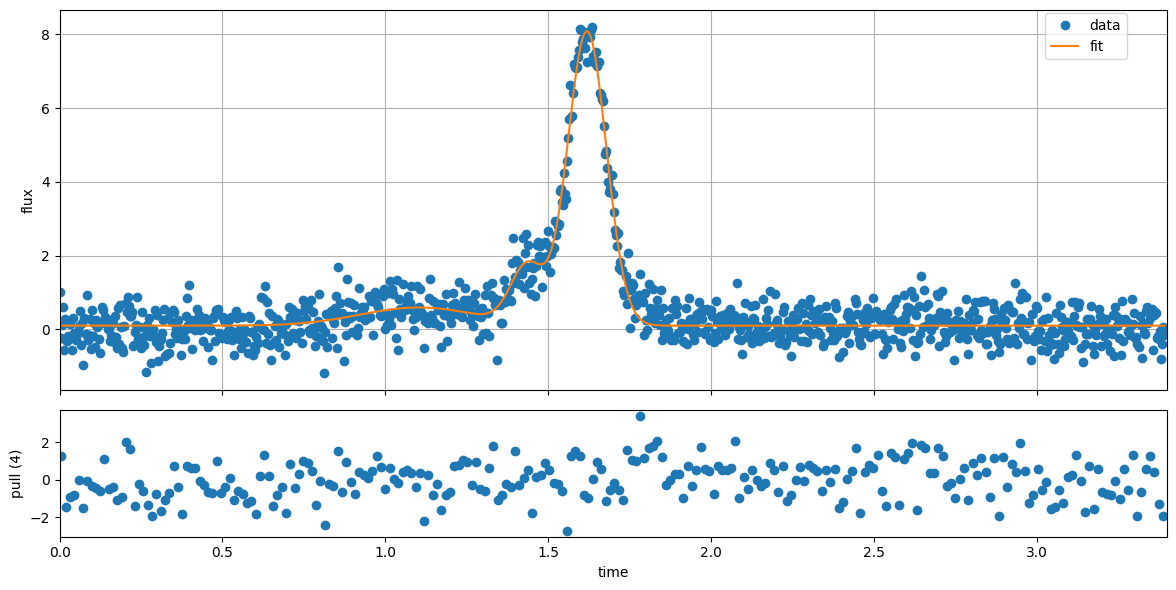

In [5]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(time, flux, marker='o', linestyle='', label="data")

ax1.plot(time, model(time, np.array(m.values)), label = "fit")

ax1.set(xlim=(0, 3.4))
ax1.grid()
ax1.legend(bbox_to_anchor=(0.97,1.01))
ax1.set(ylabel="flux")

rebin = 4
residual = flux - model(time, np.array(m.values))
res_bin = np.mean(np.reshape(residual,(1024//rebin,-1)), axis=1)
pull_bin = res_bin / np.mean(np.reshape(flux_err,(1024//rebin,-1)), axis=1) * np.sqrt(rebin)
time_bin = np.mean(np.reshape(time,(1024//rebin,-1)), axis=1)

ax2.plot(time_bin, pull_bin, marker='o', linestyle='')
ax2.set(ylabel=f"pull ({rebin})", xlabel ="time")

plt.tight_layout()
plt.show()

In [6]:
chi2ndf = []
pulls_good = []
pulls_bad = []
arrival = []
arrival_err = []
a1a3 = []

ndata = np.max(df['pulse_number'].to_numpy())
for i in range(ndata+1):
    first = df[df['pulse_number'] == i]

    flux = first['flux'].to_numpy()
    time = first['time'].to_numpy()

    # Estimate uncertainty from last quarter of signal
    flux_err = np.full_like(flux, np.sqrt(np.var(flux[767:])))


    maximum = np.max(flux)
    maxpos = time[np.argmax(flux)]
    args = np.array([maximum/7.0, maxpos, 0.06,
                     0.2, 1.1, 0.15,
                     0.2, 1.4, 0.04,
                     0.0])
    m = Minuit(LSQ, args, name=("A1","μ1", "σ1", "A2","μ2", "σ2", "A3","μ3", "σ3", "n"))
    m.errordef=1
    m.migrad()
    chi2ndf.append(m.fval / (len(time)-len(args)))
    residual = flux - model(time, np.array(m.values))
    res_bin = np.mean(np.reshape(residual,(1024//rebin,-1)), axis=1)
    if 1000*m.values["μ1"] > 1600:
        pulls_good.append(res_bin / np.mean(np.reshape(flux_err,(1024//rebin,-1)), axis=1) * np.sqrt(rebin))
    else:   
        pulls_bad.append(res_bin / np.mean(np.reshape(flux_err,(1024//rebin,-1)), axis=1) * np.sqrt(rebin))
    arrival.append(1000*m.values["μ1"])
    arrival_err.append(1000*m.errors["μ1"])
    a1a3.append(m.values["A3"]/m.values["A1"])

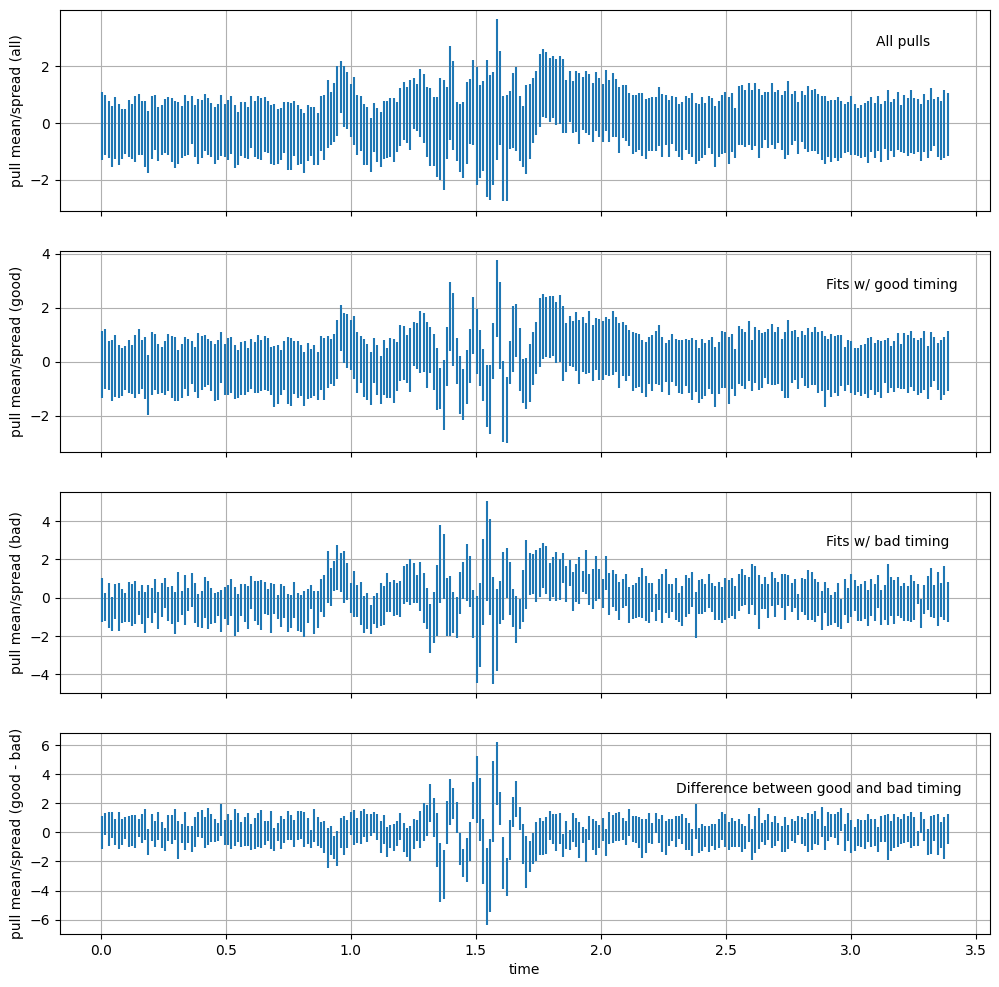

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,12), sharex=True)

pulls_good_arr = np.array(pulls_good)
pulls_bad_arr = np.array(pulls_bad)
pulls_all_arr = np.array(pulls_good+pulls_bad)

mean_all = np.mean(pulls_all_arr, axis=0)
spread_all = np.sqrt(np.var(pulls_all_arr, axis=0))
ax1.set(ylabel="pull mean/spread (all)")
ax1.grid()
ax1.errorbar(time_bin,mean_all,spread_all, linestyle='')
ax1.text(3.1, 2.7, 'All pulls')

mean_good = np.mean(pulls_good_arr, axis=0)
spread_good = np.sqrt(np.var(pulls_good_arr, axis=0))
ax2.set(ylabel="pull mean/spread (good)")
ax2.grid()
ax2.errorbar(time_bin,mean_good,spread_good, linestyle='')
ax2.text(2.9, 2.7, 'Fits w/ good timing')


mean_bad = np.mean(pulls_bad_arr, axis=0)
spread_bad = np.sqrt(np.var(pulls_bad_arr, axis=0))
ax3.set(ylabel="pull mean/spread (bad)")
ax3.grid()
ax3.errorbar(time_bin,mean_bad,spread_bad, linestyle='')
ax3.text(2.9, 2.7, 'Fits w/ bad timing')

ax4.set(ylabel="pull mean/spread (good - bad)", xlabel="time")
ax4.grid()
ax4.errorbar(time_bin,mean_good - mean_bad,spread_bad, linestyle='')
ax4.text(2.3, 2.7, 'Difference between good and bad timing');



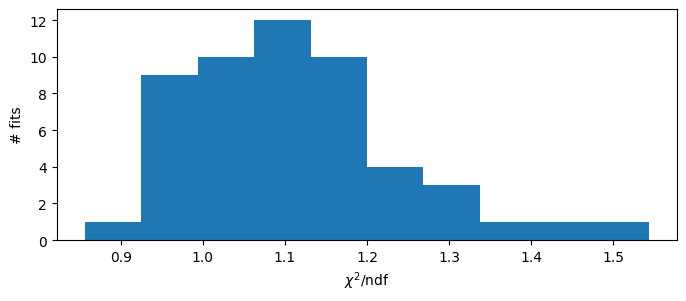

In [8]:
fig, ax = plt.subplots(1, figsize=(8,3))
ax.set(ylabel="# fits", xlabel="$\chi^2/$ndf")
ax.hist(chi2ndf,10);

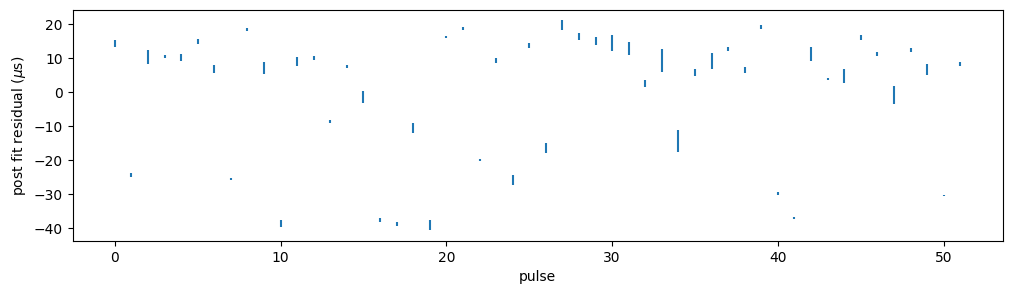

In [9]:
fig, ax = plt.subplots(1, figsize=(12,3))
ax.set(ylabel="post fit residual ($\mu$s)", xlabel="pulse")
ax.errorbar(range(ndata+1), arrival-np.mean(arrival), arrival_err, linestyle='');